In [16]:
import datetime as datetime
import pandas as pd
import numpy as np
import numpy_financial as npf
from itertools import accumulate
import absbox as abs
from absbox import API, SPV, Generic, mkDealsBy, setDealsBy,prodDealsBy, viz      #, Portfolio, Risk, Performance, Utils, Data, Analytics, Market, Risk, Utils, Data, Analytics, Market
from absbox.local.analytics import irr, run_yield_table, flow_by_scenario       #npv, 
from absbox.local.util import positionFlow
from dateutil.relativedelta import relativedelta  
from CILibrary.analytics.datetime import Date, dateFromDatetime, dateFromString
from CILibrary.common.DBase import DBase
from CILibrary.analytics.performance.performance import Performance
from CILibrary.analytics.performance.utils import get_index_stats, convert_to_prices
from tabulate import tabulate
from itertools import accumulate
from pyxirr import xirr
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  
from mpl_toolkits.mplot3d import axes3d
import time
from scipy import optimize
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter  
import seaborn as sns   
import warnings
from lenses import lens

# Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

CI_DB = DBase()
localAPI = API("https://absbox.org/api/dev",check=False)
#localAPI = API("http://localhost:8081",check=False)

Output()

✅Connected, local lib:0.26.1, server:0.26.1

Historical Loan Default Rates

In [17]:
lcd = pd.read_excel('C:\\Users\\yunyizhang\\Python script\\2. Upload data\\LLI Default Rates.xlsx', sheet_name='Default Stats', header=1)
lcd = lcd.iloc[:, :2].set_index('Date').resample('A').mean().reset_index()  
lcd = lcd.rename(columns={'Date': 'Year', 'LTM $ of Defaults / Total Outstanding': 'Loan Default Rates'}).set_index('Year')
lcd = lcd.loc['2008':'2013']
# print(lcd)  

mean = lcd['Loan Default Rates'].mean()  
st_dev = lcd['Loan Default Rates'].std()  
print("Entire History: ", "Mean: ", "{:.2%}".format(mean), "St Dev: ", "{:.2%}".format(st_dev))

threshold = 0.04
print("Annual Default Rate Threshold Above", threshold, "Mean: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] > threshold, 'Loan Default Rates'].mean()), "St Dev: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] > threshold, 'Loan Default Rates'].std()))
print("Annual Default Rate Threshold Below", threshold, ": Mean: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] <= threshold, 'Loan Default Rates'].mean()), "St Dev: ", "{:.2%}".format(lcd.loc[lcd['Loan Default Rates'] <= threshold, 'Loan Default Rates'].std()))


Entire History:  Mean:  3.07% St Dev:  3.08%
Annual Default Rate Threshold Above 0.04 Mean:  6.61% St Dev:  2.93%
Annual Default Rate Threshold Below 0.04 : Mean:  1.30% St Dev:  0.61%


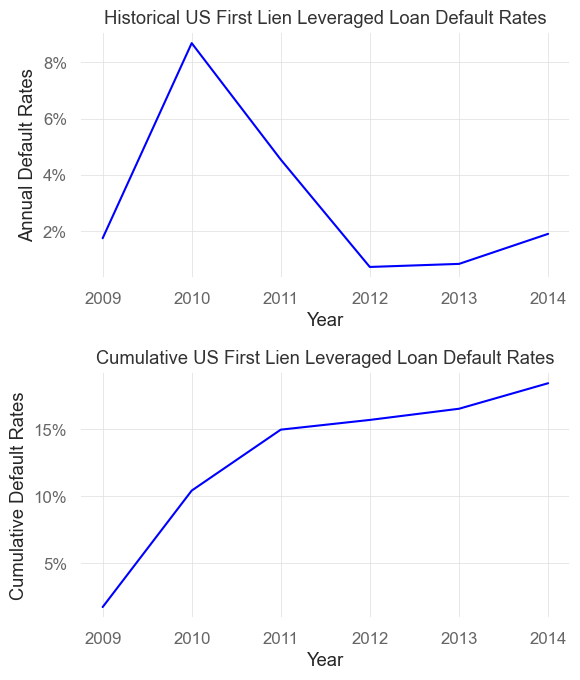

In [18]:
# lcd.loc[lcd.index.year < 2010, 'Loan Default Rates'] *= 2
# lcd.loc[lcd.index.year < 2015, 'Loan Default Rates'] *= 1.5  

fig, axs = plt.subplots(2, 1, figsize=(6, 7))  # 1 row, 2 columns
axs[0].plot(lcd.index, lcd['Loan Default Rates'], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual Default Rates')
axs[0].set_title('Historical US First Lien Leveraged Loan Default Rates')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,0))  
lcd['Cumulative Loan Default Rates'] = lcd['Loan Default Rates'].cumsum()  
axs[1].plot(lcd.index, lcd['Cumulative Loan Default Rates'], color='blue')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Cumulative Default Rates')
axs[1].set_title('Cumulative US First Lien Leveraged Loan Default Rates')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,0))
plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

Monte Carlo Simulation to Create Default Assumptions

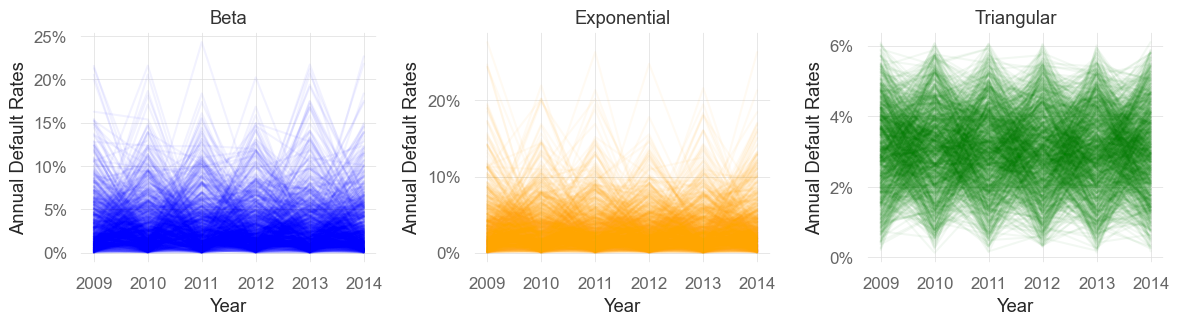

In [19]:
mean = lcd['Loan Default Rates'].mean()  
st_dev = lcd['Loan Default Rates'].std()  
maturity = len(lcd)
np.random.seed(123)  
num_scenarios = 1000
degrees_of_freedom = 10    
default_rates_beta = np.random.beta(mean*(mean*(1-mean)/st_dev**2-1), (1-mean)*(mean*(1-mean)/st_dev**2-1), size=(num_scenarios, maturity))  
default_rates_binomial = np.random.binomial(n=1, p=mean, size=(num_scenarios, maturity))  
default_rates_exponential = np.random.exponential(scale=mean, size=(num_scenarios, maturity))  
default_rates_gamma = np.random.gamma(shape=mean/st_dev**2, scale=st_dev/mean/500, size=(num_scenarios, maturity))  
default_rates_triangular = np.random.triangular(left=mean-st_dev, mode=mean, right=mean+st_dev, size=(num_scenarios, maturity))  
default_rates_lognormal = np.random.lognormal(mean=np.log(mean**2/np.sqrt(st_dev**2+mean**2)), sigma=np.sqrt(np.log(1+st_dev**2/mean**2)), size=(num_scenarios, maturity))  
default_rates_chisquare = np.random.chisquare(df=mean**2/st_dev**2, size=(num_scenarios, maturity)) * st_dev**2/mean  
default_rates_uniform = np.random.uniform(mean, st_dev, size=(num_scenarios, maturity))
default_rates_standardt = np.clip((np.random.standard_t(degrees_of_freedom, size=(num_scenarios, maturity)) * st_dev + mean), 0, 1)

# Plot the default rate scenarios for all distributions  
# distributions = ['Beta', 'Binomial', 'Exponential', 'Gamma', 'Triangular', 'Lognormal', 'ChiSquare', 'Uniform', 'StandardT']  
# colors = ['blue', 'orange', 'green', 'magenta', 'red', 'brown', 'navy', 'gray', 'pink']  
distributions = ['Beta', 'Exponential', 'Triangular']  
colors = ['blue', 'orange', 'green']  

def to_percentage(x, pos):  
    return f"{100 * x:.0f}%"  
def to_percentage_one_decimal(x, pos):  
    return f"{100 * x:.1f}%"  

plt.figure(figsize=(12, 9))  
for i, dist in enumerate(distributions):  
    plt.subplot(3, 3, i+1)  
    for j in range(num_scenarios):  
        plt.plot(lcd.index[:6], eval('default_rates_' + dist.lower())[j][:6], alpha=0.05, color=colors[i])  
        # plt.plot(range(1, 7), eval('default_rates_' + dist.lower())[j][:6], alpha=0.05, color=colors[i])  
    plt.xlabel('Year')  
    plt.ylabel('Annual Default Rates')  
    # plt.title('10,000 Scenarios of Default Rates (' + dist + ' Distribution)')  
    plt.title(dist)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage)) 
plt.tight_layout()  
plt.show()  

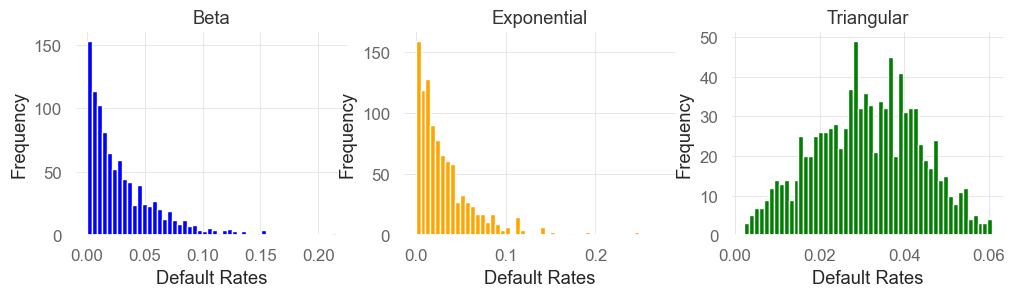

In [20]:
# plot histogram of the default rates for each distribution
plt.figure(figsize=(12, 9))
for i, dist in enumerate(distributions):
    plt.subplot(3, 3, i+1)
    plt.hist(eval('default_rates_' + dist.lower())[:, 0], bins=50, color=colors[i])
    plt.xlabel('Default Rates')
    plt.ylabel('Frequency')
    plt.title(dist)

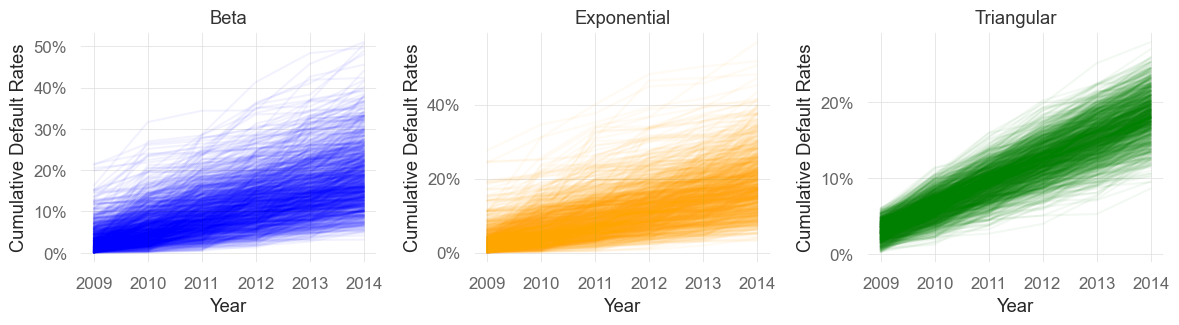

In [21]:
#plot cumulative default curve using all the above distributions 
# cumulative density function (CDF) of the default rates for each distribution
plt.figure(figsize=(12, 9))
for i, dist in enumerate(distributions):
    plt.subplot(3, 3, i+1)
    for j in range(num_scenarios):
        plt.plot(lcd.index[:6], eval('default_rates_' + dist.lower())[j][:6].cumsum(), alpha=0.05, color=colors[i])
    plt.xlabel('Year')
    plt.ylabel('Cumulative Default Rates')
    plt.title(dist)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage)) 
plt.tight_layout()
plt.show()

In [22]:
num_instances = 1_000  # Number of time series to simulate  
num_years = 6  # Number of years to simulate  
scenarios = distributions
all_scenarios_df = pd.DataFrame()  

for scenario in scenarios:  
    all_time_series = pd.DataFrame()  
      
    for n in range(num_instances):  
        if scenario == 'Triangular':  
            default_rates_scenario = default_rates_triangular[np.random.choice(num_scenarios), :]  
        elif scenario == 'Uniform':  
            default_rates_scenario = default_rates_uniform[np.random.choice(num_scenarios), :]  
        elif scenario == 'Lognormal':  
            default_rates_scenario = default_rates_lognormal[np.random.choice(num_scenarios), :]  
        elif scenario == 'Exponential':  
            default_rates_scenario = default_rates_exponential[np.random.choice(num_scenarios), :]  
        # elif scenario == 'Normal':
        #     default_rates_scenario = default_rates_normal[np.random.choice(num_scenarios), :]
        elif scenario == 'StandardT':
            default_rates_scenario = default_rates_standardt[np.random.choice(num_scenarios), :]
        elif scenario == 'Gamma':
            default_rates_scenario = default_rates_gamma[np.random.choice(num_scenarios), :]
        # elif scenario == 'Poisson':
        #     default_rates_scenario = default_rates_poisson[np.random.choice(num_scenarios), :]
        elif scenario == 'Binomial':
            default_rates_scenario = default_rates_binomial[np.random.choice(num_scenarios), :]
        elif scenario == 'ChiSquare':
            default_rates_scenario = default_rates_chisquare[np.random.choice(num_scenarios), :]
        elif scenario == 'Beta':
            default_rates_scenario = default_rates_beta[np.random.choice(num_scenarios), :]
        # elif scenario == 'Geometric':
        #     default_rates_scenario = default_rates_geometric[np.random.choice(num_scenarios), :]
        # elif scenario == 'Weibull':
        #     default_rates_scenario = default_rates_weibull[np.random.choice(num_scenarios), :]
        # elif scenario == 'Gumbel':
        #     default_rates_scenario = default_rates_gumbel[np.random.choice(num_scenarios), :]
        # elif scenario == 'Logistic':
        #     default_rates_scenario = default_rates_logistic[np.random.choice(num_scenarios), :]
        # elif scenario == 'Laplace':
        #     default_rates_scenario = default_rates_laplace[np.random.choice(num_scenarios), :]
        else:
            raise ValueError('Invalid distribution')
          
        default_rates = []  
        for year in range(num_years):  
            if year == 1:  
                default_rate = np.random.choice(default_rates_scenario*2)  
            elif year <= 3:  
                default_rate = np.random.choice(default_rates_scenario*1)  
            elif year <= 5:  
                default_rate = np.random.choice(default_rates_scenario*0.8)  
            else:  
                # default_rate = np.random.choice([0.05, 0.1, 0.15], p=[0.6, 0.3, 0.1])  
                default_rate = np.random.choice(default_rates_scenario*0.5)
            default_rates.append(default_rate)  
          
        lcd = pd.DataFrame({scenario: default_rates}, index=pd.date_range('2023-01-01', periods=num_years, freq='Y'))    
        all_time_series = pd.concat([all_time_series, lcd.T])  
      
    # Adding the median and IQR for each scenario to a summary DataFrame  
    all_time_series_transposed = all_time_series.T  
    median_rates = all_time_series_transposed.median(axis=1)  
    percentile25 = all_time_series_transposed.quantile(0.25, axis=1)  
    percentile75 = all_time_series_transposed.quantile(0.75, axis=1)  
      
    scenario_summary = pd.DataFrame({  
        f'{scenario}_median': median_rates,  
        f'{scenario}_25th': percentile25,  
        f'{scenario}_75th': percentile75  
    })  
      
    if all_scenarios_df.empty:  
        all_scenarios_df = scenario_summary  
    else:  
        all_scenarios_df = all_scenarios_df.join(scenario_summary)  
  
# Now `all_scenarios_df` contains the median and IQR for each year, for all scenarios.  
# You can plot these using a similar approach as before, adjusting for multiple scenarios in the loop.  

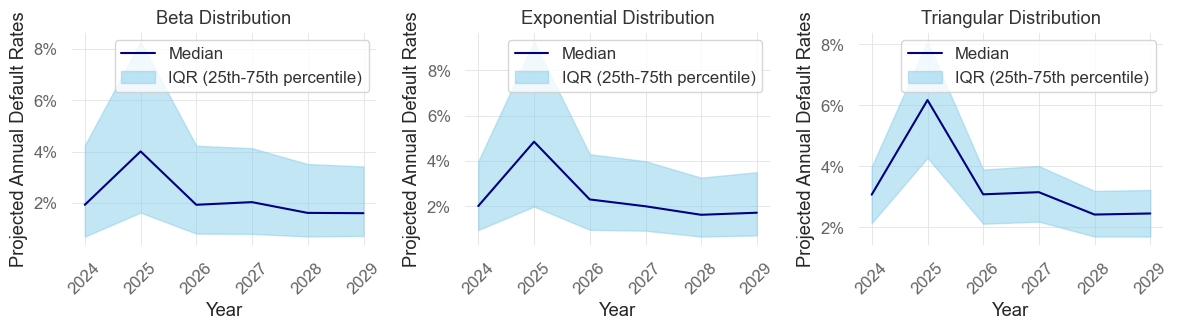

In [23]:
# Set the figure size and create subplots for each scenario  
rows = int(np.ceil(len(distributions) /3))  
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(12, 3.5))  
axes = axes.flatten()  # Flatten to iterate easily  
scenarios = distributions  
  
for i, scenario in enumerate(scenarios):  
    median_label = f'{scenario}_median'  
    p25_label = f'{scenario}_25th'  
    p75_label = f'{scenario}_75th'  
        
    # Plot median  
    axes[i].plot(all_scenarios_df.index, all_scenarios_df[median_label], label='Median', color='navy')  
        
    # Fill between the 25th and 75th percentile (IQR)  
    axes[i].fill_between(all_scenarios_df.index, all_scenarios_df[p25_label], all_scenarios_df[p75_label], color='skyblue', alpha=0.5, label='IQR (25th-75th percentile)')  
        
    # Customize the plot  
    axes[i].set_title(f'{scenario} Distribution')  
    axes[i].set_xlabel('Year')  
    axes[i].set_ylabel('Projected Annual Default Rates')  
        
    # Adjusting X-axis labels  
    axes[i].xaxis.set_major_locator(mdates.YearLocator())  
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
    axes[i].tick_params(axis='x', rotation=45)  
        
    # Format y-axis as percentage  
    axes[i].yaxis.set_major_formatter(FuncFormatter(to_percentage))  
    axes[i].legend()  
  
plt.tight_layout()  
plt.show()  

Create Collateral Pool Cash Flows

In [24]:
all_time_series.columns = [f'Year {i+1}' for i in range(6)]
all_time_series.index = range(1, 1001)
all_time_series

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6
1,0.007637,0.081345,0.027658,0.014455,0.032538,0.026211
2,0.034090,0.012173,0.006086,0.051386,0.041109,0.041109
3,0.029822,0.059644,0.033100,0.033100,0.023857,0.039629
4,0.021439,0.035206,0.037359,0.046248,0.014082,0.022791
5,0.031979,0.095289,0.038271,0.032161,0.008925,0.038116
...,...,...,...,...,...,...
996,0.025570,0.084418,0.042209,0.025570,0.020456,0.033767
997,0.024693,0.068155,0.021918,0.035738,0.019754,0.033886
998,0.027675,0.077320,0.027675,0.031561,0.010492,0.023230
999,0.009782,0.076341,0.009782,0.009782,0.030536,0.007826


In [4]:
import datetime as datetime
from dateutil.relativedelta import relativedelta  

In [5]:
# Pool assumptions 
original_pool_balance = 3_000_000_000
original_pool_term = 3*12
base_rate = 0.04
pool_rate = 0.07 + base_rate
default_rate = 0.01  #[0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
# defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
pool_cpr = 12 / original_pool_term   # amortization rate
recovery_rate = 1 - (0.3 * 0.7 + 0.15 * 0.3)   #sensitize this
recovery_lag = 6   #in months

# Deal assumptions
start_date = '2024-01-31' 
original_deal_term = 120      #! change to 120
repay_month = 36               # sensitize this with [24, 30, 36, 42, 48]    
months_to_call = 72
tranche_size_equity = 0.10     #sensitize this, when set to 1, is it just the pool
tranche_size_mezz = 0.10 
tranche_size_senior = 1 - tranche_size_equity - tranche_size_mezz
tranche_rate_equity = 0.10 + base_rate     #this is coupon rate on the tranche  
tranche_rate_mezz = 0.05 + base_rate
tranche_rate_senior = 0.01 + base_rate
issue_price = 1   #can assume back leverage with a value between 0 and 1
reinvestment_rate = 0.00      #replenishment rate for the defaulted positions need to make assumptions too    #risk free rate 

# Remaining calcs
first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+1)  
first_pay_date = first_pay_date.strftime('%Y-%m-%d')
repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
repay_date = repay_date.strftime('%Y-%m-%d')  
deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
deal_call_date = deal_call_date.strftime('%Y-%m-%d')  
pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  


In [6]:
import absbox as abs
from absbox import API, SPV, Generic, mkDealsBy, setDealsBy,prodDealsBy, viz      #, Portfolio, Risk, Performance, Utils, Data, Analytics, Market, Risk, Utils, Data, Analytics, Market
from absbox.local.analytics import irr, run_yield_table, flow_by_scenario       #npv, 
from absbox.local.util import positionFlow
import matplotlib.pyplot as plt
from pyxirr import xirr
from lenses import lens
from itertools import accumulate
import pandas as pd
import numpy as np
#import numpy_financial as npf

In [7]:
localAPI = API("https://absbox.org/api/dev",check=False)
#localAPI = API("http://localhost:8081",check=False)

⠸ Connecting engine server -> https://absbox.org/api/dev

✅Connected, local lib:0.26.0, server:0.26.2

In [8]:
perf = ("Pool"            #this is for new assets added into the pool
        ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
        ,None
        ,None
       )

test01 = Generic(
    "TEST01"
    ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
     ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date} #! change deal date
    ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
          ,"freq":"Monthly","type":"Even","originDate":start_date}
          ,{"currentBalance":original_pool_balance
          ,"currentRate":pool_rate
          ,"remainTerm":original_pool_term
          ,"status":"current"}]]}
    ,(("acc01",{"balance":0}),("acc02",{"balance":0}))  #! change to 0
    ,(("S",{"balance":original_pool_balance * tranche_size_senior
             ,"rate":tranche_rate_senior
             ,"originBalance":original_pool_balance * tranche_size_senior
             ,"originRate":tranche_rate_senior
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_senior}
             ,"bondType":{"Sequential":None}})
      ,("M",{"balance":original_pool_balance * tranche_size_mezz
             ,"rate":tranche_rate_mezz
             ,"originBalance":original_pool_balance * tranche_size_mezz
             ,"originRate":tranche_rate_mezz
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_mezz}
             ,"bondType":{"Sequential":None}
             })
      ,("E",{"balance":original_pool_balance * tranche_size_equity
             ,"rate":tranche_rate_equity
             ,"originBalance":original_pool_balance * tranche_size_equity
             ,"originRate":tranche_rate_equity
             ,"startDate":start_date
             ,"rateType":{"Fixed":tranche_rate_equity}
             ,"bondType":{"Sequential":None}
             }))
    ,list()
    ,{"revolving":[
          ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
          ,['transfer',"acc02","acc01"]
          # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
          ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
           
         ]
      ,"amortizing":[
          ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
          ,['transfer',"acc02","acc01"]
          # ,['payPrinBySeq',"acc01",["S","M","E"]]
          ,['payPrin',"acc01",["S","M","E"]]
          ,['payIntResidual',"acc01","E"]
       ]
     }
    ,[["CollectedPrincipal","acc01"]
      ,["CollectedRecoveries","acc01"] #! add here
      ,["CollectedPrepayment","acc01"] #! add here
      ,["CollectedInterest","acc02"]]
    ,None
    ,None
    ,None    
    ,{"BeforeDistribution":
       {"dealStatusChange":
        {"condition":[">=",repay_date]
            ,"effects":("newStatus","Amortizing")
            ,"status":False
            ,"curable":False}}
         }
    ,("PreClosing","Revolving")
    )

runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
                    ,["constant"
                      ,["Mortgage"     ##this is what the new assets look like 
                        ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                          ,"freq":"Monthly","type":"Level","originDate":repay_date}
                          ,{"currentBalance":original_pool_balance
                          ,"currentRate":pool_rate
                          ,"remainTerm":original_pool_term
                          ,"status":"current"}]]
                    ,perf)]

r = localAPI.run(test01
                ,runAssump = runDealAssump
                ,poolAssump = ("Pool"
                              ,("Mortgage",{"CDR":0.01},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
                              ,None
                              ,None)
                ,read=True)

⠦

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from absbox.local.chart import viz

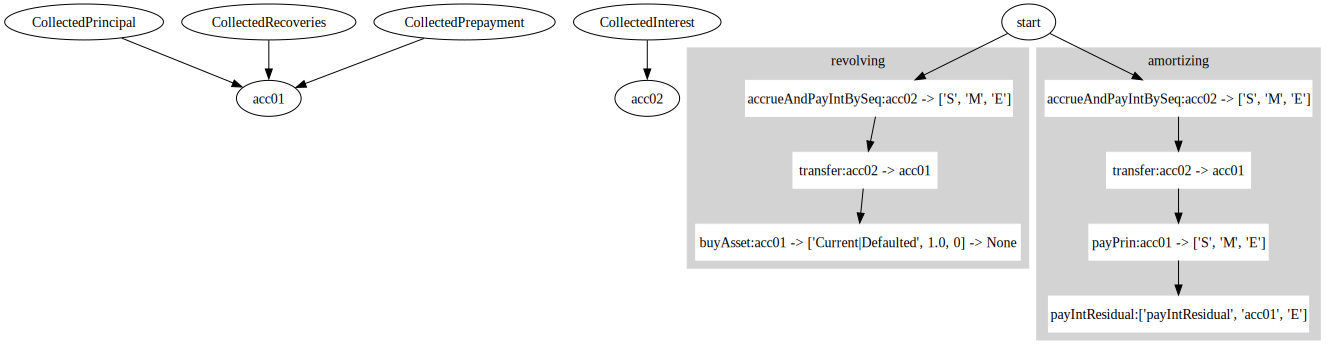

In [25]:
viz(test01)

In [153]:
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.set_option('display.max_rows', None)

In [154]:
r['pool']['flow']

,Balance,Principal,Interest,Prepayment,Default,Recovery,Loss,WAC,BorrowerNum,PrepayPenalty,CumPrincipal,CumPrepay,CumDelinq,CumDefault,CumRecovery,CumLoss
Date,,,,,,,,,,,,,,,,
2024-01-31,"3,000,000,000.000",0.000,0.000,0.000,0.000,0.000,0.000,0.110,None,None,0.000,0.000,0,0.000,0.000,0.000
2024-02-29,"2,955,971,988.420","41,633,408.280","27,476,051.060",0.000,"2,394,603.300",0.000,0.000,0.110,None,None,"41,633,408.280",0.000,0,"2,394,603.300",0.000,0.000
2024-03-31,"2,964,598,846.150","42,123,561.300","27,559,617.570","777,312.830","2,565,289.140",0.000,0.000,0.110,None,None,"83,231,293.860","777,312.830",0,"4,916,715.340",0.000,0.000
2024-04-30,"2,972,280,722.820","42,613,897.000","27,634,524.070","1,618,375.780","2,494,287.470",0.000,0.000,0.110,None,None,"125,323,293.820","2,395,688.610",0,"7,365,997.830",0.000,0.000
2024-05-31,"2,980,499,144.610","43,118,307.850","27,714,477.550","2,414,692.310","2,581,128.340",0.000,0.000,0.110,None,None,"167,376,031.980","3,973,204.260",0,"9,858,194.550",0.000,0.000
2024-06-30,"2,988,326,340.550","43,628,393.150","27,790,897.060","3,228,679.880","2,511,153.960",0.000,0.000,0.110,None,None,"211,036,883.960","8,039,060.800",0,"12,373,162.630",0.000,0.000
2024-07-31,"2,996,666,623.620","44,152,363.420","27,872,146.800","4,025,359.850","2,595,717.190",0.000,0.000,0.110,None,None,"252,473,854.910","8,711,242.030",0,"14,742,331.850",0.000,0.000
2024-08-31,"3,004,457,242.170","44,680,069.290","27,948,392.570","4,919,102.030","2,608,025.420","1,783,979.450","610,623.840",0.110,None,None,"295,540,581.720","11,946,138.540",0,"17,216,275.150","1,783,979.450","610,623.840"
2024-09-30,"3,014,309,788.600","45,237,939.300","28,043,814.430","5,651,720.980","2,537,281.850","1,911,140.390","654,148.730",0.110,None,None,"343,584,469.240","22,635,243.660",0,"19,994,085.300","3,662,952.910","1,253,762.410"


In [70]:
r['accounts']['acc01']

,balance,change,memo
date,,,
2024-01-31,0.000,0.000,<Pool:CollectedPrincipal>
2024-02-29,"41,666,666.660","41,666,666.660",<Pool:CollectedPrincipal>
2024-02-29,"54,148,228.320","12,481,561.660","<Transfer:acc02,acc01>"
2024-03-31,"95,814,894.980","41,666,666.660",<Pool:CollectedPrincipal>
2024-03-31,"106,878,923.530","11,064,028.550","<Transfer:acc02,acc01>"
2024-03-31,0.000,"-106,878,923.530",<PurchaseAsset:>
2024-04-30,"42,704,768.250","42,704,768.250",<Pool:CollectedPrincipal>
2024-04-30,"54,868,972.710","12,164,204.460","<Transfer:acc02,acc01>"
2024-05-31,"97,566,278.850","42,697,306.140",<Pool:CollectedPrincipal>


<Axes: xlabel='Date'>

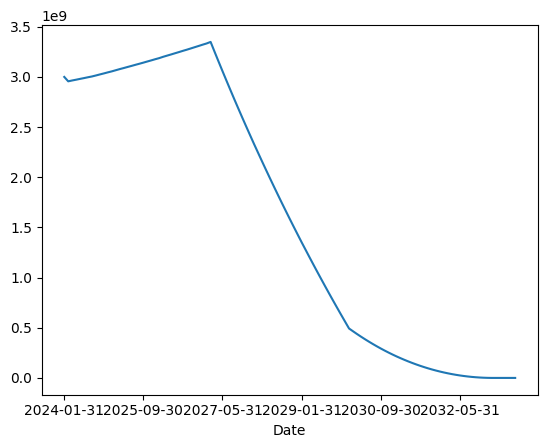

In [155]:
r['pool']['flow'].Balance.plot()

In [156]:
r['pool']['flow'].Default

Date
2024-01-31           0.000
2024-02-29   2,394,603.300
2024-03-31   2,565,289.140
2024-04-30   2,494,287.470
2024-05-31   2,581,128.340
2024-06-30   2,511,153.960
2024-07-31   2,595,717.190
2024-08-31   2,608,025.420
2024-09-30   2,537,281.850
2024-10-31   2,621,718.270
2024-11-30   2,557,979.210
2024-12-31   2,640,111.440
2025-01-31   2,657,408.310
2025-02-28   2,417,508.710
2025-03-31   2,664,922.690
2025-04-30   2,611,004.200
2025-05-31   2,689,227.270
2025-06-30   2,632,890.070
2025-07-31   2,708,764.190
2025-08-31   2,731,407.710
2025-09-30   2,664,905.990
2025-10-31   2,739,471.250
2025-11-30   2,687,693.730
2025-12-31   2,759,842.970
2026-01-31   2,785,908.740
2026-02-28   2,544,469.880
2026-03-31   2,784,345.930
2026-04-30   2,745,862.410
2026-05-31   2,814,359.050
2026-06-30   2,769,981.510
2026-07-31   2,836,009.790
2026-08-31   2,867,585.780
2026-09-30   2,805,128.010
2026-10-31   2,870,232.050
2026-11-30   2,830,250.060
2026-12-31   2,892,810.160
2027-01-31   2,927,856.

<Axes: xlabel='Date'>

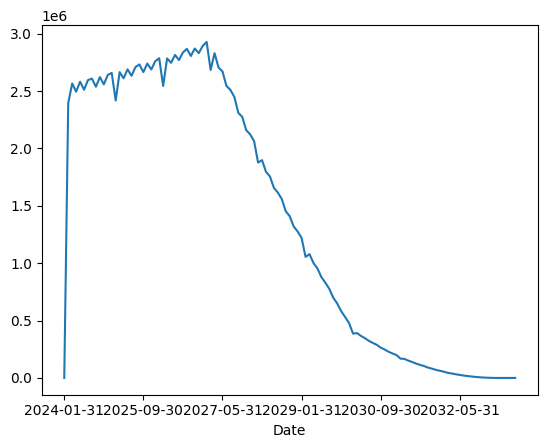

In [157]:
r['pool']['flow'].Default.plot()

In [158]:
_r = localAPI.runAsset("2024-02-01",
                        [["Mortgage"     ##this is what the new assets look like 
                           ,{"originBalance":106_878_923.530,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                           ,"freq":"Monthly","type":"Level","originDate":"2024-03-31"}
                           ,{"currentBalance":106_878_923.530
                           ,"currentRate":pool_rate
                           ,"remainTerm":original_pool_term
                           ,"status":"current"}]]
                   ,poolAssump=("Pool",("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
                                         ,None
                                         ,None)
                   ,read=True)
_r[0].loc[["2025-01-31","2025-02-28","2025-03-31"]]

⠸

,余额,本金,利息,早偿金额,违约金额,回收金额,损失金额,利率,债务人数量,早偿手续费,累计还款,累计早偿,累计拖欠,累计违约,累计回收,累计损失
日期,,,,,,,,,,,,,,,,
2025-01-31,"81,605,005.480","974,380.990","756,922.650","1,288,680.720","71,619.520","62,821.840","21,502.780",0.110,None,None,"10,059,940.340","14,413,045.390",0,"800,932.320","257,186.360","88,030.210"
2025-02-28,"79,440,670.920","968,907.680","737,034.190","1,132,534.920","62,891.960","61,157.690","20,933.160",0.110,None,None,"11,028,848.020","15,545,580.310",0,"863,824.280","318,344.050","108,963.370"
2025-03-31,"77,191,337.370","961,942.950","716,352.960","1,219,609.760","67,780.840","57,605.770","19,717.410",0.110,None,None,"11,990,790.970","16,765,190.070",0,"931,605.120","375,949.820","128,680.780"


In [85]:
(81_605_005.480) * (1-(1-0.01)**(28/365))

62891.960590562834

In [87]:
79_440_670.920 * (1-(1-0.01)**(31/365))

67780.84302066341

<Axes: xlabel='Date'>

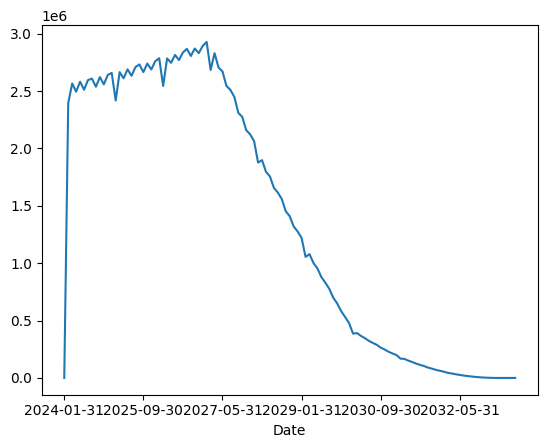

In [159]:
r['pool']['flow'].Default.plot()

In [25]:
def srt(firstLossBal, poolPerformance, issuePrice, feeRate, reinvestRate=reinvestment_rate):
    
    poolDates = poolPerformance['pool']['flow'].index.to_list()
    beginDate = poolDates[0]
    lastDate = poolDates[-1]
    start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
    start['CumLossDerived'] = start['Loss'].cumsum()
    
    #start.loc[:,'FeeBase'] = (start[''] - start['CumLoss']).clip(lower=0).to_list()#Balance
    start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLossDerived']).clip(lower=0).to_list()#tranche balance
    start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * feeRate / 12
    
    start.loc[:,'feePayment'] = start['Balance'] * feeRate / 12
    start.loc[:,'reimburseLoss'] = start['Loss']
    start.loc[:,'netGuarantor'] = start['feePayment'] - start['reimburseLoss']

    start.loc[:,'cashAccountChange'] = 0
    start.loc[beginDate, 'cashAccountChange'] = issuePrice
    start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLossDerived']

    start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
    start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12

    start.loc[:,'netCashflow'] = 0 
    start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
    # start.loc[:,'netCashflow'] += start['feePayment'].fillna(0)
    start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
    start.loc[:,'netCashflow'] += start['cashAccountInt']
    start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']    

    return start

projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
projectCf.to_clipboard()
xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())

/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_66895/666084375.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start['CumLossDerived'] = start['Loss'].cumsum()
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_66895/666084375.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLossDerived']).clip(lower=0).to_list()#tranche balance
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_66895/666084375.py:11: Sett

0.10578582712767574

In [26]:
moic = projectCf['netCashflow'].cumsum() + original_pool_balance * tranche_size_equity * issue_price
moic = moic.tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
moic

Date
2029-12-31    1.525241
Name: netCashflow, dtype: float64

In [27]:
pool_cf = r['pool']['flow']

# defaults = pool_cf['CumDefault'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# defaults
# recoveries = pool_cf['CumRecovery'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# recoveries
# losses = pool_cf['CumLoss'].tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# losses

defaults = pool_cf['Default'].cumsum()
defaults = defaults.tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
defaults
# recoveries = pool_cf['Recovery'].cumsum()
# recoveries = recoveries.tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# recoveries
# losses = pool_cf['Loss'].cumsum()
# losses = losses.tail(1) / (original_pool_balance * tranche_size_equity * issue_price)
# losses

Date
2029-12-31    0.84843
Name: Default, dtype: float64

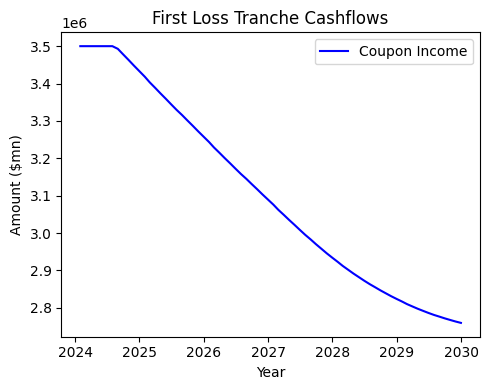

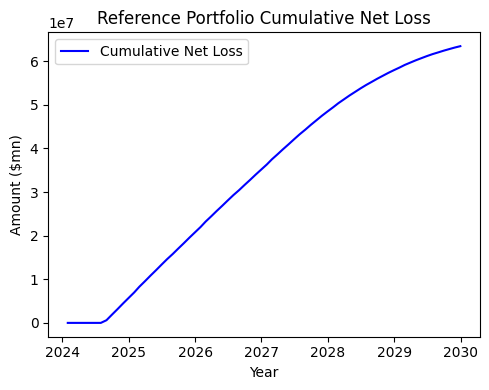

In [109]:
# projectCf = projectCf / 1_000_000
projectCf
projectCf.index = pd.to_datetime(projectCf.index)  

#make a line chart for "interestStream" and "netCashflow"
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(projectCf.index, projectCf['interestStream'], label='Coupon Income', color='blue')
# ax.plot(projectCf.index, projectCf['netCashflow'], label='Net Cashflow', color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Amount ($mn)')
ax.set_title('First Loss Tranche Cashflows')
# ax.yaxis.set_major_formatter(FuncFormatter(to_percentage_one_decimal))
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(projectCf.index, projectCf['CumLossDerived'], label='Cumulative Net Loss', color='blue')
# ax.plot(projectCf.index, projectCf['netCashflow'], label='Net Cashflow', color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Amount ($mn)')
ax.set_title('Reference Portfolio Cumulative Net Loss')
# ax.yaxis.set_major_formatter(FuncFormatter(to_percentage_one_decimal))
ax.legend()
plt.tight_layout()
plt.show()

In [160]:
rWithLargerLag = localAPI.run(test01
                ,runAssump = runDealAssump
                ,poolAssump = ("Pool"
                              ,("Mortgage",{"CDR":0.01},None,{"Rate":recovery_rate,"Lag":recovery_lag+3},None)
                              ,None
                              ,None)
                ,read=True)

⠏

In [161]:
clo_like_equity_tranche = r['bonds']['E']['cash']
#clo_like_equity_tranche = rWithLargerLag['bonds']['E']['cash']
initial_investment = original_pool_balance * tranche_size_equity * issue_price


clo_like_equity_tranche = pd.concat([pd.Series(-1*initial_investment, index=[start_date]), clo_like_equity_tranche])

#clo_like_equity_tranche = clo_like_equity_tranche.append()
clo_like_equity_tranche.sort_index(inplace=True)
clo_like_equity_tranche


xirr(clo_like_equity_tranche.index.to_list(),clo_like_equity_tranche.to_list())

# #chart the cash column
# fig, ax = plt.subplots(figsize=(5,4))
# ax.plot(projectCf.index, projectCf['cashAccountBal'], label='Cash Account Balance', color='blue')
# ax.set_xlabel('Year')
# ax.set_ylabel('Amount ($mn)')
# ax.set_title('First Loss Tranche Cash Account Balance')
# # ax.yaxis.set_major_formatter(FuncFormatter(to_percentage_one_decimal))
# ax.legend()
# plt.tight_layout()
# plt.show()


0.3607302094100259

In [162]:
#clo_like_equity_tranche = r['bonds']['E']['cash']
clo_like_equity_tranche = rWithLargerLag['bonds']['E']['cash']
initial_investment = original_pool_balance * tranche_size_equity * issue_price


clo_like_equity_tranche = pd.concat([pd.Series(-1*initial_investment, index=[start_date]), clo_like_equity_tranche])

#clo_like_equity_tranche = clo_like_equity_tranche.append()
clo_like_equity_tranche.sort_index(inplace=True)
clo_like_equity_tranche


xirr(clo_like_equity_tranche.index.to_list(),clo_like_equity_tranche.to_list())

# #chart the cash column
# fig, ax = plt.subplots(figsize=(5,4))
# ax.plot(projectCf.index, projectCf['cashAccountBal'], label='Cash Account Balance', color='blue')
# ax.set_xlabel('Year')
# ax.set_ylabel('Amount ($mn)')
# ax.set_title('First Loss Tranche Cash Account Balance')
# # ax.yaxis.set_major_formatter(FuncFormatter(to_percentage_one_decimal))
# ax.legend()
# plt.tight_layout()
# plt.show()


0.36030687492242547

In [129]:
rWithLargerLag['pool']['flow']

,Balance,Principal,Interest,Prepayment,Default,Recovery,Loss,WAC,BorrowerNum,PrepayPenalty,CumPrincipal,CumPrepay,CumDelinq,CumDefault,CumRecovery,CumLoss
Date,,,,,,,,,,,,,,,,
2024-01-31,"3,000,000,000.000",0.000,0.000,0.000,0.000,0.000,0.000,0.110,None,None,0.000,0.000,0,0.000,0.000,0.000
2024-02-29,"2,955,971,988.420","41,633,408.280","27,476,051.060",0.000,"2,394,603.300",0.000,0.000,0.110,None,None,"41,633,408.280",0.000,0,"2,394,603.300",0.000,0.000
2024-03-31,"2,964,598,846.150","42,123,561.300","27,559,617.570","777,312.830","2,565,289.140",0.000,0.000,0.110,None,None,"83,231,293.860","777,312.830",0,"4,916,715.340",0.000,0.000
2024-04-30,"2,972,280,722.820","42,613,897.000","27,634,524.070","1,618,375.780","2,494,287.470",0.000,0.000,0.110,None,None,"125,323,293.820","2,395,688.610",0,"7,365,997.830",0.000,0.000
2024-05-31,"2,980,499,144.610","43,118,307.850","27,714,477.550","2,414,692.310","2,581,128.340",0.000,0.000,0.110,None,None,"167,376,031.980","3,973,204.260",0,"9,858,194.550",0.000,0.000
2024-06-30,"2,988,326,340.550","43,628,393.150","27,790,897.060","3,228,679.880","2,511,153.960",0.000,0.000,0.110,None,None,"211,036,883.960","8,039,060.800",0,"12,373,162.630",0.000,0.000
2024-07-31,"2,996,666,623.620","44,152,363.420","27,872,146.800","4,025,359.850","2,595,717.190",0.000,0.000,0.110,None,None,"252,473,854.910","8,711,242.030",0,"14,742,331.850",0.000,0.000
2024-08-31,"3,004,457,242.170","44,680,069.290","27,948,392.570","4,919,102.030","2,608,025.420",0.000,0.000,0.110,None,None,"295,540,581.720","11,946,138.540",0,"17,216,275.150",0.000,0.000
2024-09-30,"3,012,571,122.090","45,220,611.730","28,027,718.990","5,625,208.670","2,535,808.790","32,166.930","11,010.160",0.110,None,None,"343,567,141.670","22,608,731.350",0,"19,992,612.240","32,166.930","11,010.160"


In [94]:
r['bonds']['E']

,balance,interest,principal,rate,cash,factor,memo
date,,,,,,,
2024-02-29,"300,000,000.000","3,336,986.300",0.000,0.140,"3,336,986.300",1.000,<PayInt:E>
2024-03-31,"300,000,000.000","3,567,123.280",0.000,0.140,"3,567,123.280",1.000,<PayInt:E>
2024-04-30,"300,000,000.000","3,452,054.790",0.000,0.140,"3,452,054.790",1.000,<PayInt:E>
2024-05-31,"300,000,000.000","3,567,123.280",0.000,0.140,"3,567,123.280",1.000,<PayInt:E>
2024-06-30,"300,000,000.000","3,452,054.790",0.000,0.140,"3,452,054.790",1.000,<PayInt:E>
2024-07-31,"300,000,000.000","3,567,123.280",0.000,0.140,"3,567,123.280",1.000,<PayInt:E>
2024-08-31,"300,000,000.000","3,567,123.280",0.000,0.140,"3,567,123.280",1.000,<PayInt:E>
2024-09-30,"300,000,000.000","3,452,054.790",0.000,0.140,"3,452,054.790",1.000,<PayInt:E>
2024-10-31,"300,000,000.000","3,567,123.280",0.000,0.140,"3,567,123.280",1.000,<PayInt:E>


In [32]:
# # pool_cf = pool_cf / 1_000_000
# pool_cf
# pool_cf.index = pd.to_datetime(pool_cf.index)  

# fig, ax = plt.subplots(figsize=(5,4))
# ax.plot(pool_cf.index, pool_cf['CumDefault'], label='Cumulative Default', color='blue')
# ax.plot(pool_cf.index, pool_cf['CumRecovery'], label='Cumulative Recovery', color='red')
# ax.set_xlabel('Year')
# ax.set_ylabel('Amount ($mn)')
# ax.set_title('Reference Portfolio Cumulative Default and Recovery')
# # ax.yaxis.set_major_formatter(FuncFormatter(to_percentage_one_decimal))
# ax.legend()
# plt.tight_layout()
# plt.show()

In [33]:
# pool_cf = r['pool']['flow']
# pool_cf.index = pd.to_datetime(pool_cf.index)  

# # create the stacked line chart  
# plt.figure(figsize=(6,5))
# # plt.stackplot(pool_cf.index, pool_cf['Balance'] / 1_000_000, pool_cf['Principal']/ 1_000_000, pool_cf['Default']/ 1_000_000, labels=['Asset Balance', 'Principal Amort', 'Default'])  
# plt.stackplot(pool_cf.index, (pool_cf['Balance'] / 1_000_000).clip(upper=3000), projectCf['netGuarantor']/ 1_000_000, labels=['Asset Balance', 'Guarantee Fee Net of Loss'])  
# plt.legend(loc='best')  
# plt.title('Portfolio Balance')  
# plt.xlabel('Year')  
# plt.ylabel('Pool Balance ($mn)')  
# plt.show()  


# bond_cf = r['bonds']['S'].loc[:,'balance'].rename('Senior Balance').to_frame()
# bond_cf1 = r['bonds']['M'].loc[:,'balance'].rename('Mezz Balance').to_frame()
# bond_cf2 = projectCf
# # bond_cf2 = projectCf.loc[projectCf.index >= first_pay_date]  
# merged = bond_cf.join([bond_cf1, bond_cf2], how='outer')  
# merged.index = pd.to_datetime(merged.index)  

# plt.figure(figsize=(6,5))  
# plt.stackplot(merged.index, merged['Senior Balance'] / 1_000_000, merged['Mezz Balance']/ 1_000_000, merged['protectedTrancheBalance']/ 1_000_000, labels=['Senior', 'Mezzanine', 'First Loss'])
# plt.legend(loc='best')    
# plt.title('Deal Balance')    
# plt.xlabel('Year')    
# plt.ylabel('Capital Stack Balance ($mn)')    
# plt.show()  

In [34]:
# viz(test01) 

VARIABLE DEFAULT RATE VECTOR

In [ ]:
# default_rate = [0.03]*36 + [0.01]*36    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 


default_rates = np.arange(0.005, 0.05, 0.001).tolist()  

#PUT IN VECTOR LOOP

DEFAULT RATES & TRANCHE THICKNESS

In [43]:
# print('\nModel Test Results: DEFAULT RATES AND TRANCHE THICKNESS')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# # original_balance = 1000000000
# default_rates = np.arange(0.005, 0.05, 0.001).tolist()  
# tranche_size_equitys = np.arange(0.08, 0.12, 0.0025).tolist()  
# df = pd.DataFrame(columns=['Constant Default Rate', 'Tranche Size', 'IRR'])  

# for default_rate in default_rates:
#     for tranche_size_equity in tranche_size_equitys:
#         perf = ("Pool"            #this is for new assets added into the pool
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":pool_maturity_date}
#             ,{'assets':[["Mortgage"             #this is snapshot at issuance, confirmed unchanged. this is a fact
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Even","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),("acc02",{"balance":original_pool_balance}))
#             ,(("S",{"balance":original_pool_balance * tranche_size_senior
#                     ,"rate":tranche_rate_senior
#                     ,"originBalance":original_pool_balance * tranche_size_senior
#                     ,"originRate":tranche_rate_senior
#                     ,"startDate":start_date
#                     ,"rateType":{"Fixed":tranche_rate_senior}
#                     ,"bondType":{"Sequential":None}})
#             ,("M",{"balance":original_pool_balance * tranche_size_mezz
#                     ,"rate":tranche_rate_mezz
#                     ,"originBalance":original_pool_balance * tranche_size_mezz
#                     ,"originRate":tranche_rate_mezz
#                     ,"startDate":start_date
#                     ,"rateType":{"Fixed":tranche_rate_mezz}
#                     ,"bondType":{"Sequential":None}
#                     })
#             ,("E",{"balance":original_pool_balance * tranche_size_equity
#                     ,"rate":tranche_rate_equity
#                     ,"originBalance":original_pool_balance * tranche_size_equity
#                     ,"originRate":tranche_rate_equity
#                     ,"startDate":start_date
#                     ,"rateType":{"Fixed":tranche_rate_equity}
#                     ,"bondType":{"Sequential":None}
#                     }))
#             ,list()
#             ,{"revolving":[
#                 ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
#                 ,['transfer',"acc02","acc01"]
#                 # ,['WriteOff',["E","M","S"]]             #this is the write off of the defaulted assets
#                 ,["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#             ,"amortizing":[
#                 ["accrueAndPayIntBySeq","acc02",["S","M","E"]]
#                 ,['transfer',"acc02","acc01"]
#                 # ,['payPrinBySeq',"acc01",["S","M","E"]]
#                 ,['payPrin',"acc01",["S","M","E"]]
#                 ,['payIntResidual',"acc01","E"]
#             ]
#             }
#             ,[["CollectedPrincipal","acc01"]
#             ,["CollectedInterest","acc02"]]
#             ,None
#             ,None
#             ,None    
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",repay_date]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         runDealAssump = [("revolving"     #this is asumption about what happens during the revolving period, we care about what assets we buy, and hows their performance
#                             ,["constant"
#                             ,["Mortgage"     ##this is what the new assets look like 
#                                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                 ,"freq":"Monthly","type":"Level","originDate":repay_date}
#                                 ,{"currentBalance":original_pool_balance
#                                 ,"currentRate":pool_rate
#                                 ,"remainTerm":original_pool_term
#                                 ,"status":"current"}]]
#                             ,perf)]

#         r = localAPI.run(test01
#                         ,runAssump = runDealAssump
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, feeRate, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
#             start['CumLossDerived'] = start['Loss'].cumsum()
            
#             #start.loc[:,'FeeBase'] = (start[''] - start['CumLoss']).clip(lower=0).to_list()#Balance
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLossDerived']).clip(lower=0).to_list()#tranche balance
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * feeRate / 12
            
#             start.loc[:,'feePayment'] = start['Balance'] * feeRate / 12
#             start.loc[:,'reimburseLoss'] = start['Loss']
#             start.loc[:,'netGuarantor'] = start['feePayment'] - start['reimburseLoss']

#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLossDerived']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12

#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             # start.loc[:,'netCashflow'] += start['feePayment'].fillna(0)
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']    

#             return start


#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Constant Default Rate': default_rate, 'Tranche Size': tranche_size_equity, 'IRR': a}, ignore_index=True)
#         print('Default Rate: ', default_rate, ' & Tranche Size: ', tranche_size_equity, ' & IRR: ', a)

In [44]:
# df = df.sort_values(by='IRR', ascending=True)
# df.to_clipboard()

# # Convert values to percentages  
# df["Constant Default Rate"] = (df["Constant Default Rate"] * 100).round(2)  
# df["Tranche Size"] = (df["Tranche Size"] * 100).round(2)   
# df["IRR"] = (df["IRR"] * 100).round(2)  

# #round the percentage to 2 decimal places
# df["Constant Default Rate"] = df["Constant Default Rate"].round(2)


# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Constant Default Rate", "Tranche Size", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Tranche Size (%)')  
# ax.set_ylabel('Average Loss Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [45]:
# # Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
# selected_rates = [0.5 * i for i in range(1, 11)]  
# selected_df = df[df['Constant Default Rate'].isin(selected_rates)]  
  
# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = selected_df.pivot("Tranche Size", "Constant Default Rate", "IRR")  
  
# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Loss Rate')  
#     # plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column:.2%} Default Rate')    

# plt.xlabel('Tranche Size (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Tranche Size for Different Average Loss Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
# # plt.ylim(top=20)   # Set the y-axis limit to 20%

# plt.show()  

REPLENISHMENT PERIOD

In [40]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: REPLENISHMENT PERIOD AND TRANCHE RATE')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# # original_balance = 1000000000
# repay_months = np.arange(21, 48, 3).tolist()  
# tranche_rate_equitys = np.arange(0.08, 0.15, 0.01).tolist()  
# df = pd.DataFrame(columns=['Replenishment Period', 'Tranche Rate', 'IRR'])  

# for repay_month in repay_months:
#     for tranche_rate_equity in tranche_rate_equitys:
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Replenishment Period': repay_month, 'Tranche Rate': tranche_rate_equity, 'IRR': a}, ignore_index=True)
#         print('Replenishment Period: ', repay_month, ' & Tranche Rate: ', tranche_rate_equity, ' & IRR: ', a)

In [ ]:
# df.to_clipboard()

# # Convert values to percentages  
# # df["Replenishment Period"] *= 100  
# df["Tranche Rate"] *= 100  
# df["IRR"] *= 100  

# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Tranche Rate", "Replenishment Period", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Replenishment Period (Months)')  
# ax.set_ylabel('Tranche Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Replenishment Period", "Tranche Rate", "IRR")  
  
# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Tranche Rate')  
  
# plt.xlabel('Replenishment Period (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Replenishment Period for Different Tranche Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
  
# plt.show()  

TRANCHE RATE AND COLLATERAL POOL RATE

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: TRANCHE AND COLLATERAL COUPON RATES')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# tranche_rate_equitys = np.arange(0.05, 0.15, 0.01).tolist()  
# pool_rates = np.arange(0.04, 0.2, 0.01).tolist()  
# df = pd.DataFrame(columns=['Tranche Rate', 'Pool Rate', 'IRR'])  

# for tranche_rate_equity in tranche_rate_equitys:
#     for pool_rate in pool_rates:
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Tranche Rate': tranche_rate_equity, 'Pool Rate': pool_rate, 'IRR': a}, ignore_index=True)
#         print('Tranche Rate: ', tranche_rate_equity, ' & Pool Rate: ', pool_rate, ' & IRR: ', a)

In [ ]:
# df = df.sort_values(by='IRR', ascending=True)
# df.to_clipboard()

# # Convert values to percentages  
# df["Tranche Rate"] = (df["Tranche Rate"] * 100).round(2)  
# df["Pool Rate"] = (df["Pool Rate"] * 100).round(2)   
# df["IRR"] = (df["IRR"] * 100).round(2)  

# #round the percentage to 2 decimal places
# df["Tranche Rate"] = df["Tranche Rate"].round(2)


# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Tranche Rate", "Pool Rate", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Tranche Rate (%)')  
# ax.set_ylabel('Pool Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # # Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
# # selected_rates = [0.5 * i for i in range(1, 11)]  
# # selected_df = df[df['Constant Default Rate'].isin(selected_rates)]  
  
# # Pivot the DataFrame to create a 2D grid of IRR values  
# # pivot_table = selected_df.pivot("Tranche Size", "Constant Default Rate", "IRR")  
# pivot_table = df.pivot("Tranche Rate", "Pool Rate", "IRR")  

# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Pool Rate')  
#     # plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column:.2%} Default Rate')    

# plt.xlabel('Tranche Rate (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Tranche Rate for Different Collateral Pool Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
# # plt.ylim(top=20)   # Set the y-axis limit to 20%

# plt.show()  

RECOVERY RATE AND LAG TIME

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
# print('\nModel Test Results: TRANCHE AND COLLATERAL COUPON RATES')

# # LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# recovery_rates = np.arange(0.0, 1.0, 0.05).tolist()  
# recovery_lags = np.arange(0, 24, 1).tolist()  
# df = pd.DataFrame(columns=['Recovery Rate', 'Recovery Lag', 'IRR'])  

# for recovery_rate in recovery_rates:
#     for recovery_lag in recovery_lags:
#         perf = ("Pool"
#                 ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                 ,None
#                 ,None
#             )

#         test01 = Generic(
#             "TEST01"
#             ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
#             ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
#             ,{'assets':[["Mortgage"
#                 ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                 ,"freq":"Monthly","type":"Level","originDate":start_date}
#                 ,{"currentBalance":original_pool_balance
#                 ,"currentRate":pool_rate
#                 ,"remainTerm":original_pool_term
#                 ,"status":"current"}]]}
#             ,(("acc01",{"balance":0}),)
#             ,list()
#             ,list()
#             ,{"default":[
#                 ["IfElse"
#                 ,["status","Revolving"]
#                 ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
#                 ]
#                 ,[]
#                 ]
#                 ]
#             }
#             ,[["CollectedCash","acc01"]]
#             ,None
#             ,None
#             ,None
#             ,{"BeforeDistribution":
#             {"dealStatusChange":
#                 {"condition":[">=",f"{repay_date}" ]
#                     ,"effects":("newStatus","Amortizing")
#                     ,"status":False
#                     ,"curable":False}}
#                 }
#             ,("PreClosing","Revolving")
#             )

#         r = localAPI.run(test01
#                         ,runAssump = [("revolving"
#                                         ,["constant"
#                                         ,["Mortgage"
#                                             ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
#                                             ,"freq":"Monthly","type":"Level","originDate":start_date}
#                                             ,{"currentBalance":original_pool_balance
#                                             ,"currentRate":tranche_rate_equity
#                                             ,"remainTerm":original_pool_term
#                                             ,"status":"current"}]]
#                                         ,perf)]
#                         ,poolAssump = ("Pool"
#                                     ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
#                                     ,None
#                                     ,None)
#                         ,read=True)

#         def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
#             poolDates = poolPerformance['pool']['flow'].index.to_list()
#             beginDate = poolDates[0]
#             lastDate = poolDates[-1]
            
#             start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
#             start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
#             start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
#             start.loc[:,'cashAccountChange'] = 0
#             start.loc[beginDate, 'cashAccountChange'] = issuePrice
#             start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

#             start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
#             start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
#             start.loc[:,'netCashflow'] = 0 
#             start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
#             start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
#             start.loc[:,'netCashflow'] += start['cashAccountInt']
#             start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
#             return start

#         projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
#         a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
#         df = df.append({'Recovery Rate': recovery_rate, 'Recovery Lag': recovery_lag, 'IRR': a}, ignore_index=True)
#         print('Recovery Rate: ', recovery_rate, ' & Recovery Lag: ', recovery_lag, ' & IRR: ', a)

In [ ]:
# df.to_clipboard()

# # Convert values to percentages  
# # df["Replenishment Period"] *= 100  
# df["Recovery Rate"] *= 100  
# df["IRR"] *= 100  

# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = df.pivot("Recovery Rate", "Recovery Lag", "IRR")  
  
# # Convert the pivot table index and columns to np.meshgrid format  
# X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
# Z = pivot_table.values  
  
# # Plotting  
# fig = plt.figure()  
# ax = fig.add_subplot(111, projection='3d')  
  
# # Plot the 3D surface  
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# # Add color bar which maps values to colors  
# fig.colorbar(surf, shrink=0.5, aspect=5)  

# # Setting the axes labels with '%' sign  
# ax.set_xlabel('Recovery Lag (Months)')  
# ax.set_ylabel('Recovery Rate (%)')  
# ax.set_zlabel('IRR (%)')  
  
# # Adjust the view angle  
# ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  
  
# plt.show()  

In [ ]:
# # Convert values to percentages  
# df["Recovery Rate"] = (df["Recovery Rate"] * 1).round(2)  
# df["IRR"] = (df["IRR"] * 1).round(2)  

# # Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
# selected_rates = [10 * i for i in range(1, 11)]  
# selected_df = df[df['Recovery Rate'].isin(selected_rates)]  
  
# # Pivot the DataFrame to create a 2D grid of IRR values  
# pivot_table = selected_df.pivot("Recovery Lag", "Recovery Rate", "IRR")  
# # pivot_table = df.pivot("Recovery Lag", "Recovery Rate", "IRR")  
  
# # Plotting  
# plt.figure(figsize=(12, 8))  
  
# # Loop through the columns (each column is a different Constant Default Rate) to plot them  
# for column in pivot_table.columns:  
#     plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}% Recovery Rate')  
  
# plt.xlabel('Recovery Lag (%)')  
# plt.ylabel('IRR (%)')  
# plt.title('IRR vs. Recovery Lag for Different Recovery Rates')  
# plt.legend(loc='best')  # Show legend to identify lines  
# plt.grid(True)  # Add grid for better readability  
  
# plt.show()  

REPLENISHMENT PERIOD AND DEAL LIFE

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
print('\nModel Test Results: REPLENISHMENT PERIOD AND TRANCHE RATE')

# LOOP THROUGH THE DEFAULT RATES AND TRANCHE THICKNESS TO CALCULATE THE IRR
# original_balance = 1000000000

repay_months = np.arange(0, 72, 3).tolist()  
months_to_calls = np.arange(0, 72, 3).tolist()  
df = pd.DataFrame(columns=['Replenishment Period', 'Deal Life', 'IRR'])  

for repay_month in repay_months:
    for months_to_call in months_to_calls:
        # date = datetime.date(2024, 1, 31)  
        start_date = '2024-01-31'
        first_pay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+1)  
        first_pay_date = first_pay_date.strftime('%Y-%m-%d')
        # repay_month = 36     #[24, 30, 36, 42, 48]     #sensitize this
        repay_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+repay_month)  
        repay_date = repay_date.strftime('%Y-%m-%d')  

        # Deal assumptions
        original_deal_maturity = 6
        original_deal_term = maturity*12
        deal_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_deal_term)
        deal_maturity_date = deal_maturity_date.strftime('%Y-%m-%d')  
        tranche_size_equity = 0.1     #sensitize this, when set to 1, is it just the pool
        issue_price = 1   #can assume back leverage with a value between 0 and 1
        tranche_rate_equity = 0.1     #make sure if this is coupon rate on the tranche  
        # months_to_call = 72
        deal_call_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+months_to_call)
        deal_call_date = deal_call_date.strftime('%Y-%m-%d')  

        # Pool assumptions 
        original_pool_balance = 3_000_000_000
        original_pool_maturity = 3
        original_pool_term = original_pool_maturity*12
        pool_maturity_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=+original_pool_term)
        pool_maturity_date = pool_maturity_date.strftime('%Y-%m-%d')  
        pool_rate = 0.07
        default_rate = 0.01    #   [0.0062]*12 + [0.0052]*12 + [0.0072]*12 + [0.0022]*12 + [0.0012]*12 + [0.0092]*12       #this is annualized to month # sensitize this with the worst historical default rates upfront 
        # defaultFactor = [["2020-10-01",1.05],["2022-10-01",1.15]]
        default_rate = default_rate
        pool_cpr = 0.25   # amortization rate
        recovery_rate = 1 - (0.3 * 0.7 + 0.15 * 0.3)   #sensitize this
        recovery_lag = 6   #in months
        reinvestment_rate = 0.00      #replenishment rate for the defaulted positions need to make assumptions too    #risk free rate 
        
        perf = ("Pool"
                ,("Mortgage",{"CDR":default_rate},{"CPR":pool_cpr},{"Rate":recovery_rate,"Lag":recovery_lag},None)
                ,None
                ,None
            )

        test01 = Generic(
            "TEST01"
            ,{"cutoff":start_date,"closing":start_date,"firstPay":first_pay_date
            ,"payFreq":"MonthEnd","poolFreq":"MonthEnd","stated":deal_maturity_date}
            ,{'assets':[["Mortgage"
                ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                ,"freq":"Monthly","type":"Level","originDate":start_date}
                ,{"currentBalance":original_pool_balance
                ,"currentRate":pool_rate
                ,"remainTerm":original_pool_term
                ,"status":"current"}]]}
            ,(("acc01",{"balance":0}),)
            ,list()
            ,list()
            ,{"default":[
                ["IfElse"
                ,["status","Revolving"]
                ,[["buyAsset",["Current|Defaulted",1.0,0],"acc01",None]
                ]
                ,[]
                ]
                ]
            }
            ,[["CollectedCash","acc01"]]
            ,None
            ,None
            ,None
            ,{"BeforeDistribution":
            {"dealStatusChange":
                {"condition":[">=",f"{repay_date}" ]
                    ,"effects":("newStatus","Amortizing")
                    ,"status":False
                    ,"curable":False}}
                }
            ,("PreClosing","Revolving")
            )

        r = localAPI.run(test01
                        ,runAssump = [("revolving"
                                        ,["constant"
                                        ,["Mortgage"
                                            ,{"originBalance":original_pool_balance,"originRate":["fix",pool_rate],"originTerm":original_pool_term
                                            ,"freq":"Monthly","type":"Level","originDate":start_date}
                                            ,{"currentBalance":original_pool_balance
                                            ,"currentRate":tranche_rate_equity
                                            ,"remainTerm":original_pool_term
                                            ,"status":"current"}]]
                                        ,perf)
                                        ,("call",{"afterDate":deal_call_date})
                                        ]
                        ,poolAssump = ("Pool"
                                    ,("Mortgage",{"CDR":default_rate},None,{"Rate":recovery_rate,"Lag":recovery_lag},None)
                                    ,None
                                    ,None)
                        ,read=True)

        def srt(firstLossBal, poolPerformance, issuePrice, coupon, reinvestRate=reinvestment_rate):
            
            poolDates = poolPerformance['pool']['flow'].index.to_list()
            beginDate = poolDates[0]
            lastDate = poolDates[-1]
            
            start = poolPerformance['pool']['flow'][['Balance','Loss','CumLoss']]
            
            start.loc[:,'protectedTrancheBalance'] = (firstLossBal - start['CumLoss']).clip(lower=0).to_list()
            
            start.loc[:,'interestStream'] = start['protectedTrancheBalance'] * coupon / 12
            
            start.loc[:,'cashAccountChange'] = 0
            start.loc[beginDate, 'cashAccountChange'] = issuePrice
            start.loc[lastDate, 'cashAccountChange'] = -1*start.loc[lastDate, 'CumLoss']

            start.loc[:,'cashAccountBal'] = list(accumulate([issuePrice]+start['cashAccountChange'].to_list()[1:]))
            start.loc[:,'cashAccountInt'] = start['cashAccountBal'].shift(1,fill_value=0) * reinvestRate/12
            
            start.loc[:,'netCashflow'] = 0 
            start.loc[beginDate,'netCashflow'] = -1 * start.loc[beginDate,'cashAccountChange']
            start.loc[:,'netCashflow'] += start['interestStream'].fillna(0)
            start.loc[:,'netCashflow'] += start['cashAccountInt']
            start.loc[lastDate,'netCashflow'] = start.loc[lastDate,'cashAccountBal']
            return start

        projectCf = srt(original_pool_balance * tranche_size_equity, r, original_pool_balance * tranche_size_equity * issue_price, tranche_rate_equity,reinvestRate=reinvestment_rate)
        a = xirr(projectCf.index.to_list(),projectCf['netCashflow'].to_list())
        df = df.append({'Replenishment Period': repay_month, 'Deal Life': months_to_call, 'IRR': a}, ignore_index=True)
        print('Replenishment Period: ', repay_month, ' & Deal Life: ', months_to_call, ' & IRR: ', a)


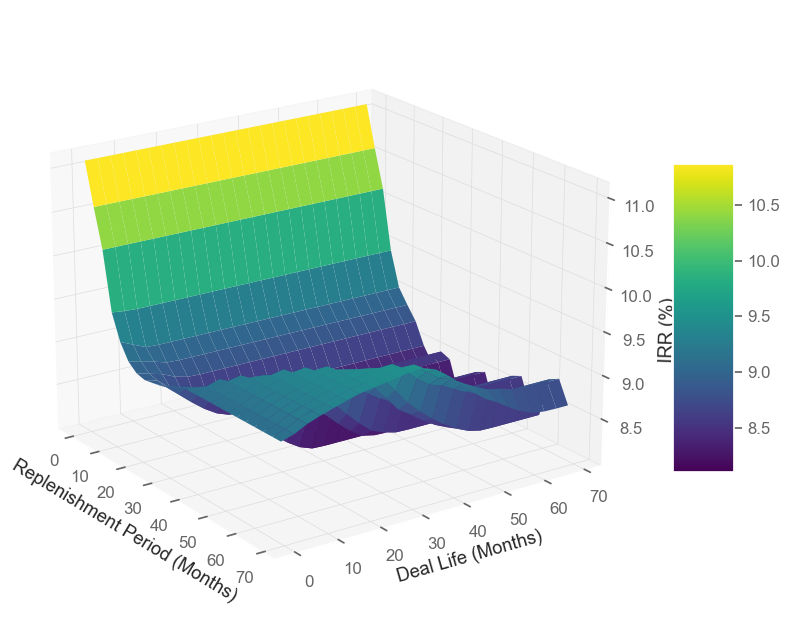

In [ ]:
df.to_clipboard()

# Convert values to percentages  
df["Replenishment Period"] = (df["Replenishment Period"] * 1).round(0)
df["Deal Life"] = (df["Deal Life"] * 1).round(0)
df["IRR"] *= 100 

# Pivot the DataFrame to create a 2D grid of IRR values  
pivot_table = df.pivot("Replenishment Period", "Deal Life", "IRR")  
  
# Convert the pivot table index and columns to np.meshgrid format  
X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)  
Z = pivot_table.values  
  
# Plotting  
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')  
  
# Plot the 3D surface  
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')  
  
# Add color bar which maps values to colors  
fig.colorbar(surf, shrink=0.5, aspect=5)  

# Setting the axes labels with '%' sign  
ax.set_xlabel('Replenishment Period (Months)')  
ax.set_ylabel('Deal Life (Months)')  
ax.set_zlabel('IRR (%)')  
  
# Adjust the view angle  
ax.view_init(elev=20, azim=-35) # Feel free to adjust these angles as needed  

plt.show()  

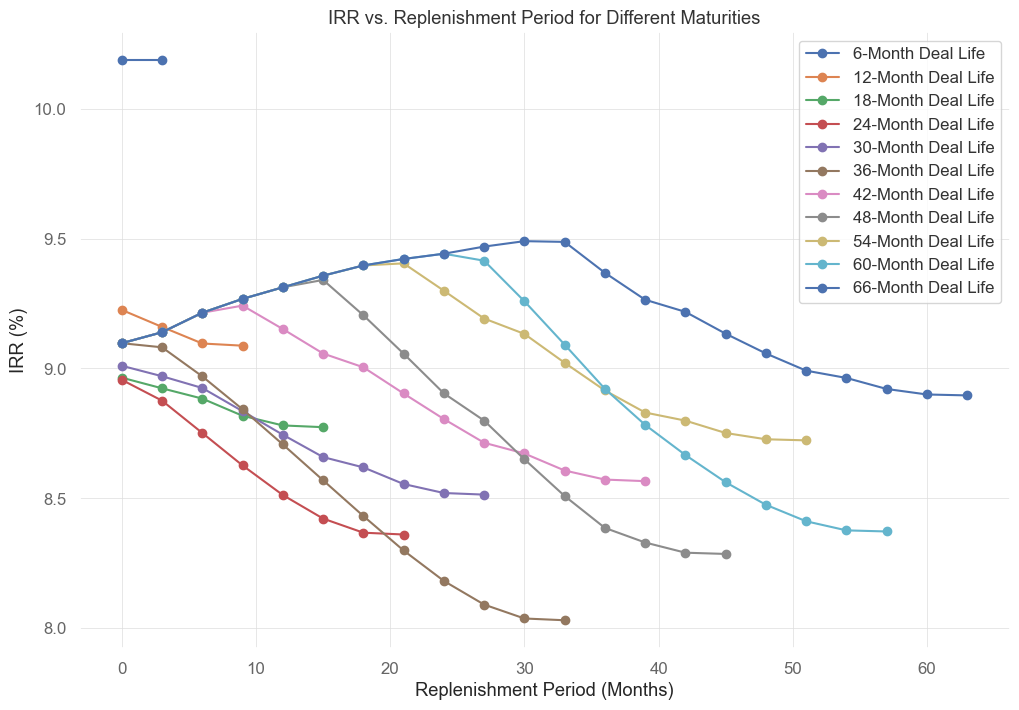

In [ ]:
# Filter the DataFrame to select only the rows that have default rates in 0.5% increments  
selected_dates = [6 * i for i in range(1, 13)]  
selected_df = df[df['Deal Life'].isin(selected_dates)]  

# select only the rows where deal life is longer than replenishment period
selected_df = selected_df[selected_df['Deal Life'] > selected_df['Replenishment Period']]
selected_df["Deal Life"] = selected_df["Deal Life"].astype(int)

# Pivot the DataFrame to create a 2D grid of IRR values  
pivot_table = selected_df.pivot("Replenishment Period", "Deal Life", "IRR")  
# pivot_table = df.pivot("Replenishment Period", "Deal Life", "IRR")  
  
# Plotting  
plt.figure(figsize=(12, 8))  
  
# Loop through the columns (each column is a different Constant Default Rate) to plot them  
for column in pivot_table.columns:  
    plt.plot(pivot_table.index, pivot_table[column], marker='o', label=f'{column}-Month Deal Life')  

plt.xlabel('Replenishment Period (Months)')  
plt.ylabel('IRR (%)')  
plt.title('IRR vs. Replenishment Period for Different Maturities')  
plt.legend(loc='best')  # Show legend to identify lines  
plt.grid(True)  # Add grid for better readability  
  
plt.show()  

GOAL SEEK

In [ ]:
TAKE A BREAK ! 🍎 + 🍌 = 🍇 

SyntaxError: invalid character '🍎' (U+1F34E) (2835284240.py, line 1)

In [ ]:
from scipy import optimize
def f(x):
    return (x**3 - 1)  # only one real root at x = 1
def fprime(x):
    return 3*x**2
# The brentq method takes as input a bracket

sol = optimize.root_scalar(f, bracket=[0, 3], method='brentq')
sol.root, sol.iterations, sol.function_calls
(1.0, 10, 11)
# The newton method takes as input a single point and uses the derivative(s).

sol = optimize.root_scalar(f, x0=0.2, fprime=fprime, method='newton')
sol.root, sol.iterations, sol.function_calls
(1.0, 11, 22)
# The function can provide the value and derivative(s) in a single call.

def f_p_pp(x):
    return (x**3 - 1), 3*x**2, 6*x
sol = optimize.root_scalar(
    f_p_pp, x0=0.2, fprime=True, method='newton'
)
sol.root, sol.iterations, sol.function_calls
(1.0, 11, 11)
sol = optimize.root_scalar(
    f_p_pp, x0=0.2, fprime=True, fprime2=True, method='halley'
)
sol.root, sol.iterations, sol.function_calls
(1.0, 7, 8)

(1.0, 7, 8)

In [ ]:
def f(disc):
    ' Create function that calculates error between x and target '
    df = pd.DataFrame({'Income':[100*1.08**i for i in range(5)], 
                       'Discount_vector':[disc**(-i) for i in range(5)]})

    df['PV of CF'] = df['Income'] * df['Discount_vector']
    x = df['PV of CF'].sum()
    
    target = 545
    error = x - target
    return error**2     

# Starting discount rate
start = 1.04

# Find min of f starting at start
start = 1.04
discount = fmin(f, [start]) 

print(f'Discount = {discount}')

Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 13
         Function evaluations: 26
Discount = [1.03537891]


Sanity Check

put in a super simple portfolio, set default rate to 0, then make sure it gives the right IRR 
do not tranche it yet, but put in default rate, make sure IRR is close to original IRR - defaults 
then play with recovery, then tranche it 
set it up to have both attach and detach 
test to make sure cashflow logic is really tight
projectCf['netCashflow'].sum() - projectCf['cashAccountBal'].iloc[0] + projectCf['cashAccountBal'].iloc[-1]
make sure simple changes that should change the cashflow schedule, make sure model is working as expected

In [ ]:
# scenarioMap = {
#   "base":("Pool"
#           ,("Fixed",[["2024-01-01",0.3]
#                     ,["2025-01-01",0.25]
#                     ,["2026-01-01",0.2]]
#                    ,[["2024-01-01",0.9]
#                     ,["2025-01-01",0.85]
#                     ,["2026-01-01",0.8]])
#           ,None
#           ,None)
#   ,"lowUtil" :("Pool"
#               ,("Fixed",[["2024-01-01",0.3]
#                         ,["2025-01-01",0.25]
#                         ,["2026-01-01",0.2]]
#                        ,[["2024-01-01",0.85]
#                         ,["2025-01-01",0.80]
#                         ,["2026-01-01",0.75]])
#               ,None
#               ,None)
#  ,"lowPrice" : ("Pool"
#               ,("Fixed",[["2024-01-01",0.3]
#                         ,["2025-01-01",0.225]
#                         ,["2026-01-01",0.19]]
#                        ,[["2024-01-01",0.9]
#                         ,["2025-01-01",0.85]
#                         ,["2026-01-01",0.8]])
#               ,None
#               ,None)
#  }
# p = localAPI.run(projectCf,poolAssump=scenarioMap
#                      ,runAssump=[("call",{"afterDate":"2027-05-31"})
#                                 ,("report",{"dates":"MonthEnd"})]
#                      ,read=True)

# {k:irr(v['bonds']['EQ'],init=('2024-01-01',-7000))
#   for k,v in p.items()}


In [ ]:
# # Fixing random state for reproducibility
# np.random.seed(19680801)

# def randrange(n, vmin, vmax):
#     """
#     Helper function to make an array of random numbers having shape (n, )
#     with each number distributed Uniform(vmin, vmax).
#     """
#     return (vmax - vmin)*np.random.rand(n) + vmin

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# n = 100

# # For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
#     ax.scatter(xs, ys, zs, marker=m)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()